# 1. Install Required Dependencies (with GPU Support)

In [68]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install mamba-ssm pandas scikit-learn matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu118


# 2. Load and Preview Dataset

In [69]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

# Load dataset
df = pd.read_csv("filtered_Study4_Room1.csv")

# Convert to datetime and extract hour
df["date_time"] = pd.to_datetime(df["date_time"])
df["hour"] = df["date_time"].dt.hour

# Preview
df.head()

Saving filtered_Study4_Room1.csv to filtered_Study4_Room1.csv


,date_time,vav_opening[%],indoor_temp[c],indoor_rh[%],indoor_co2[ppm],indoor_illuminance[lux],occupant_number_measurement,hour
0,2018-03-09 06:00:00,0.0,22.3,32.94,455,300,1,6
1,2018-03-09 06:01:00,0.0,22.3,32.94,455,300,1,6
2,2018-03-09 06:02:00,0.0,22.3,32.94,455,294,1,6
3,2018-03-09 06:03:00,0.0,22.3,32.94,455,294,1,6
4,2018-03-09 06:04:00,0.0,22.3,32.94,455,300,1,6


# 3. Preprocess Data (Normalization + Sequence Preparation)

In [70]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Drop datetime column (not used for model input)
df_cleaned = df.drop(columns=["date_time"])

# Normalize all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_cleaned)

# Sequence length = 12 time steps (1 hour if 5-min intervals)
seq_len = 12
X_seq, y_seq = [], []

for i in range(len(scaled_data) - seq_len):
    X_seq.append(scaled_data[i:i+seq_len, :-1])   # Input features
    y_seq.append(scaled_data[i+seq_len, -1])      # Target: next occupancy

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("Input shape:", X_seq.shape)
print("Target shape:", y_seq.shape)

Input shape: (31668, 12, 6)
Target shape: (31668,)


# 4. Build PyTorch Dataset & Dataloaders

In [84]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Custom dataset
class OccupancyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Dataloaders
train_loader = DataLoader(OccupancyDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(OccupancyDataset(X_val, y_val), batch_size=64)

# Verify batch shape
sample_X, sample_y = next(iter(train_loader))
print("Sample batch input:", sample_X.shape)
print("Sample batch target:", sample_y.shape)

Sample batch input: torch.Size([64, 12, 6])
Sample batch target: torch.Size([64])


# 5. Define Mamba-Based Regression Model

In [85]:
# Set hyperparameters
dropout_rates = [0.2, 0.3]
model_dims     = [32, 64]
learning_rates = [1e-3, 5e-4]

class MambaRegressor(nn.Module):
    def __init__(self, input_dim, model_dim, dropout_rate):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.mamba_block = Mamba(d_model=model_dim)
        self.norm = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.output_head = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.mamba_block(x)
        x = self.norm(x)
        x = self.dropout(x)
        x = x[:, -1, :]
        x = self.output_head(x)
        return x.squeeze(-1)

# 6. Train the Model

In [86]:
#  Training loop (with Early Stopping)
num_epochs = 50
patience = 5                         #  Stop if no improvement in 5 epochs
best_val_loss = float("inf")        #  Track best validation loss
early_stop_counter = 0              # Count epochs without improvement

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    #  Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    #  Early Stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        best_model_state = model.state_dict()  #  Save the best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f" Early stopping triggered after {epoch+1} epochs!")
            break

# Restore best model weights
model.load_state_dict(best_model_state)

Epoch 1/50 | Train Loss: 0.0071 | Val Loss: 0.0074
Epoch 2/50 | Train Loss: 0.0069 | Val Loss: 0.0075
Epoch 3/50 | Train Loss: 0.0071 | Val Loss: 0.0070
Epoch 4/50 | Train Loss: 0.0073 | Val Loss: 0.0068
Epoch 5/50 | Train Loss: 0.0068 | Val Loss: 0.0067
Epoch 6/50 | Train Loss: 0.0065 | Val Loss: 0.0067
Epoch 7/50 | Train Loss: 0.0073 | Val Loss: 0.0067
Epoch 8/50 | Train Loss: 0.0063 | Val Loss: 0.0063
Epoch 9/50 | Train Loss: 0.0065 | Val Loss: 0.0067
Epoch 10/50 | Train Loss: 0.0070 | Val Loss: 0.0070
Epoch 11/50 | Train Loss: 0.0061 | Val Loss: 0.0062
Epoch 12/50 | Train Loss: 0.0063 | Val Loss: 0.0067
Epoch 13/50 | Train Loss: 0.0062 | Val Loss: 0.0075
Epoch 14/50 | Train Loss: 0.0061 | Val Loss: 0.0059
Epoch 15/50 | Train Loss: 0.0058 | Val Loss: 0.0063
Epoch 16/50 | Train Loss: 0.0062 | Val Loss: 0.0081
Epoch 17/50 | Train Loss: 0.0062 | Val Loss: 0.0063
Epoch 18/50 | Train Loss: 0.0056 | Val Loss: 0.0059
Epoch 19/50 | Train Loss: 0.0057 | Val Loss: 0.0058
Epoch 20/50 | Train L

<All keys matched successfully>

# Save and Load Model

In [87]:
torch.save(model.state_dict(), "best_mamba_model.pth")
print("Model saved to 'best_mamba_model.pth'")

Model saved to 'best_mamba_model.pth'


# Load the model later (optional - for inference or reuse)

In [88]:
# To reload the model later
model_loaded = MambaRegressor(input_dim=6, model_dim=model_dim, dropout_rate=dropout_rate).to(device)
model_loaded.load_state_dict(torch.load("best_mamba_model.pth"))
model_loaded.eval()  # Set to evaluation mode
print("Model loaded successfully.")

Model loaded successfully.


# 7. Plot Training vs. Validation Loss

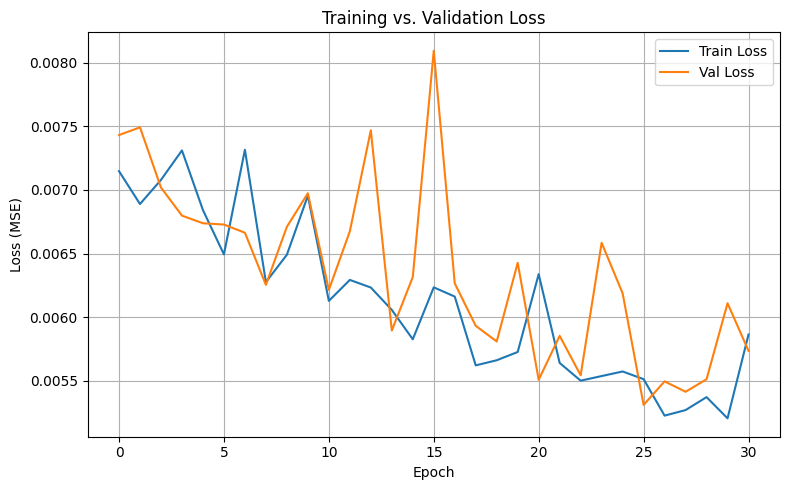

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs. Validation Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 8. Predict on Validation Set

In [90]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_true.append(y_batch.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())

# Convert to arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Inverse transform to real values
occupancy_min = scaler.data_min_[-1]
occupancy_range = scaler.data_max_[-1] - scaler.data_min_[-1]
y_true_real = y_true * occupancy_range + occupancy_min
y_pred_real = y_pred * occupancy_range + occupancy_min

# Preview first few
print("True occupancy:", y_true_real[:50].round(2))
print("Predicted     :", y_pred_real[:50].round(2))

True occupancy: [ 6.  6. 16. 13.  7. 16. 11. 13. 13. 11.  6. 11. 13. 14. 14. 14. 10. 10.
  8. 12. 17. 15. 10.  9. 15. 11. 15.  8. 17.  9. 13. 17.  8.  6. 14.  9.
 11.  7. 16. 15. 11. 17.  8. 13. 17. 14. 16. 13. 12. 15.]
Predicted     : [ 7.24  6.57 15.84 12.89  7.83 16.44 11.01 13.06 12.33  9.64  7.02 11.14
 13.15 13.6  13.55 13.9  10.03 10.42  8.59 12.26 16.38 14.96 10.65  9.24
 15.36 11.62 14.74  7.46 16.75  9.07 12.66 14.86  9.04  5.87 13.73  9.04
 10.24  7.44 16.34 16.24 10.35 16.88  7.74 13.49 16.61 14.   15.57 13.18
 12.23 15.65]


# 9. Visualize Predicted vs. True Occupancy

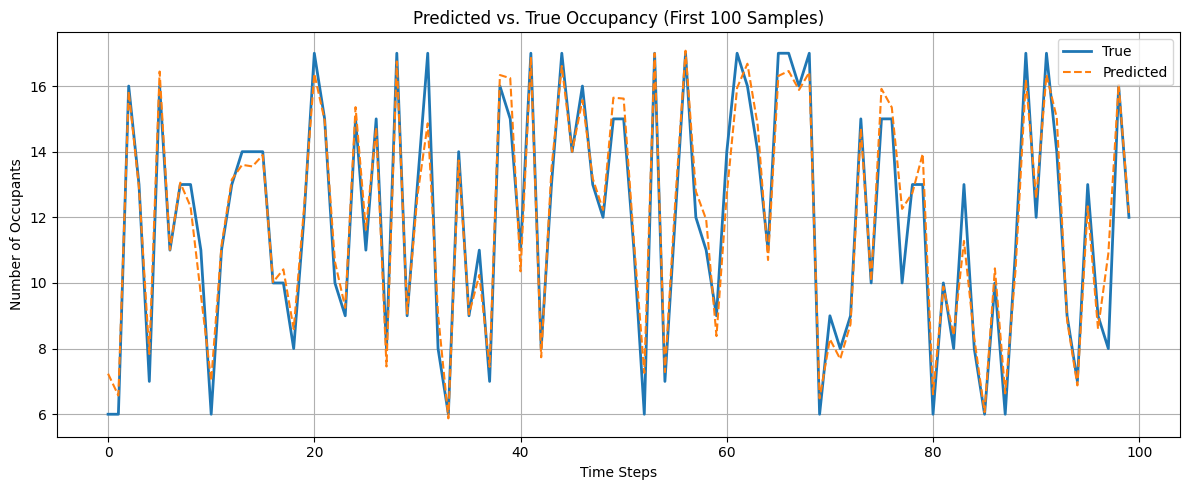

In [94]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_real[:100], label="True", linewidth=2)
plt.plot(y_pred_real[:100], label="Predicted", linestyle='--')
plt.title("Predicted vs. True Occupancy (First 100 Samples)")
plt.xlabel("Time Steps")
plt.ylabel("Number of Occupants")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Evaluate Model with Regression Metrics

In [95]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    median_absolute_error,
)

# 📊 Core metrics
mae = mean_absolute_error(y_true_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
r2 = r2_score(y_true_real, y_pred_real) * 100

# 🔍 Additional metrics
mape = mean_absolute_percentage_error(y_true_real, y_pred_real) * 100
medae = median_absolute_error(y_true_real, y_pred_real)

# 🖨️ Print results
print(f"MAE     : {mae:.2f}")
print(f"RMSE    : {rmse:.2f}")
print(f"R²      : {r2:.2f}")
print(f"MAPE    : {mape:.2f}%")
print(f"MedAE   : {medae:.2f}")

MAE     : 0.53
RMSE    : 0.83
R²      : 94.14
MAPE    : 5.29%
MedAE   : 0.40


# 11. Residual Plot (Errors vs. Time Steps)

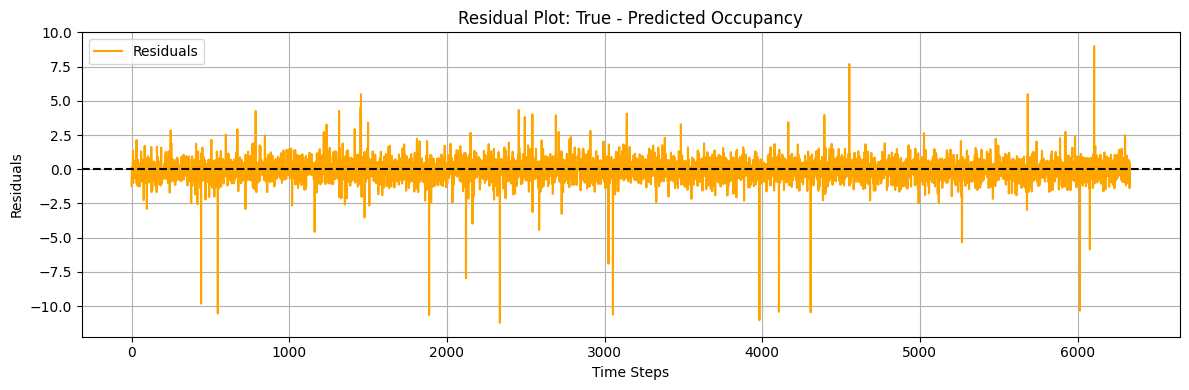

In [96]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_true_real - y_pred_real

# Plot residuals
plt.figure(figsize=(12, 4))
plt.plot(residuals, label="Residuals", color='orange')
plt.axhline(0, color='black', linestyle='--')  # Reference line at 0
plt.title("Residual Plot: True - Predicted Occupancy")
plt.xlabel("Time Steps")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

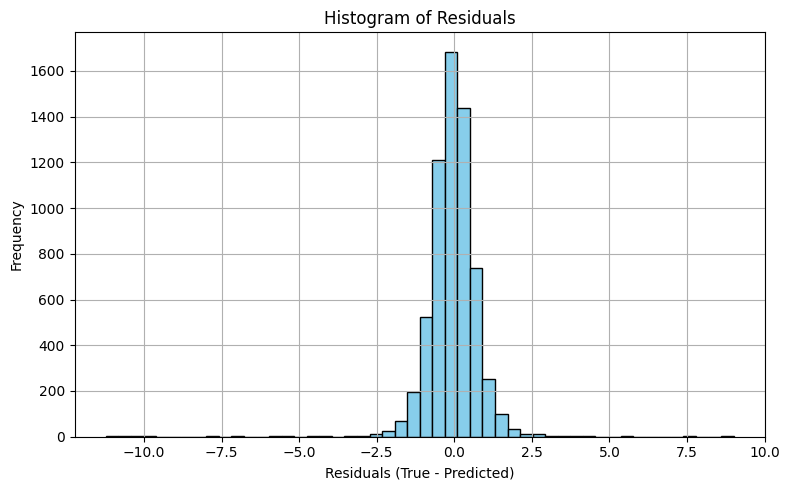

In [97]:
import matplotlib.pyplot as plt

#  Calculate residuals
residuals = y_true_real - y_pred_real

#  Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals (True - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')